#### Lung Segmentation and Classification
Lung image data and corresponding masks could be found here [Data Link](https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels)

#### Import dependencies 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate


In [2]:
INPUT_IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [3]:
root_file = "Lung Segmentation"
image_source_path = "CXR_png"
mask_source_path = "masks"
def get_valid_image_path_list(image_source_path: str, extension: str="png"):
    """
    gets a list of all valid files based on the provided extension.
    """
    image_paths = tf.io.gfile.glob(os.path.join(image_source_path, f"*.{extension}"))
        
    return sorted(image_paths)


def get_mask_path(image_path):
    if tf.strings.regex_full_match(image_path, ".*MCUCXR.*"):
        mask_path = tf.strings.regex_replace(image_path, image_source_path, mask_source_path)
        return mask_path
    
    elif tf.strings.regex_full_match(image_path, ".*CHNCXR.*"):
        mask_filename = tf.strings.regex_replace(image_path, ".png$", "_mask.png")
        mask_path = tf.strings.regex_replace(mask_filename, image_source_path, mask_source_path)
        return mask_path
    
    else:
        print("in else")
        return tf.constant("skipping")
    
def mask_exists(image_path):
    mask_path = get_mask_path(image_path)
    # convert the tensor to python str
    mask_path_str = mask_path.numpy().decode("utf-8")
    return tf.io.gfile.exists(mask_path_str)
    

def load_image_and_mask(image_path, input_image_size: tuple=(512, 512)):

    mask_path = get_mask_path(image_path)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, input_image_size)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, input_image_size)

    return image, mask



# only with valid image-mask pairs
valid_image_paths = get_valid_image_path_list(os.path.join(root_file, image_source_path))
image_with_masks_paths = [img for img in valid_image_paths if mask_exists(img)]

dataset = tf.data.Dataset.from_tensor_slices(image_with_masks_paths)

# i, m = load_image_and_mask(image_with_masks_paths[0])

dataset = dataset.map(lambda img: load_image_and_mask(img), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)


in else


In [4]:

for img, mask in dataset.take(2):
    print(f"Image: {img[0].shape}, Mask: {mask[0].shape}")


Image: (512, 512, 3), Mask: (512, 512, 1)
Image: (512, 512, 3), Mask: (512, 512, 1)


2025-02-06 21:24:01.605058: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


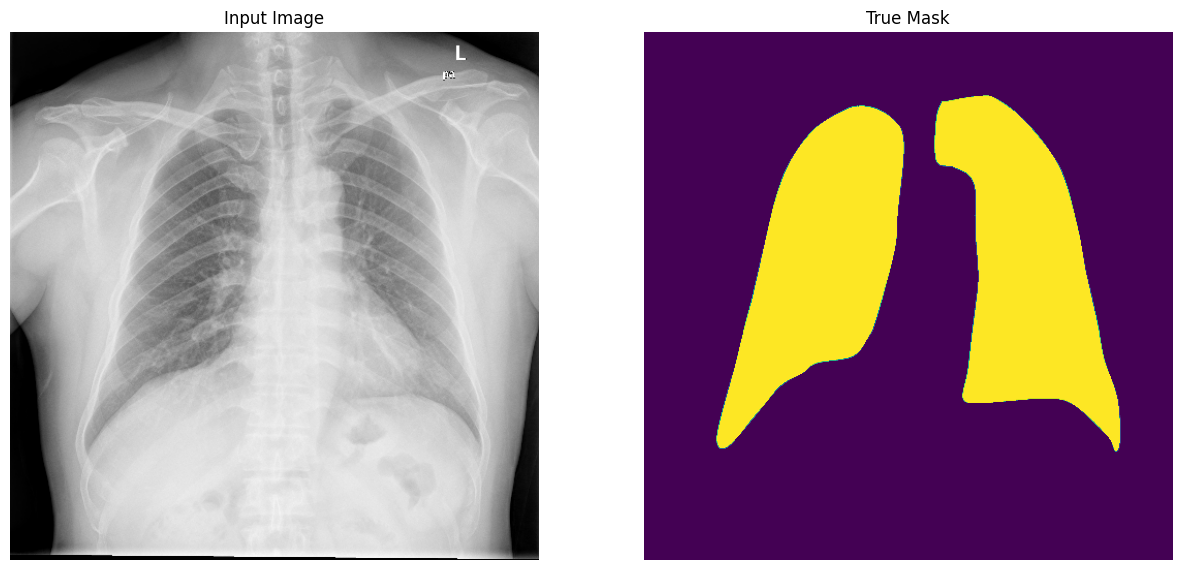

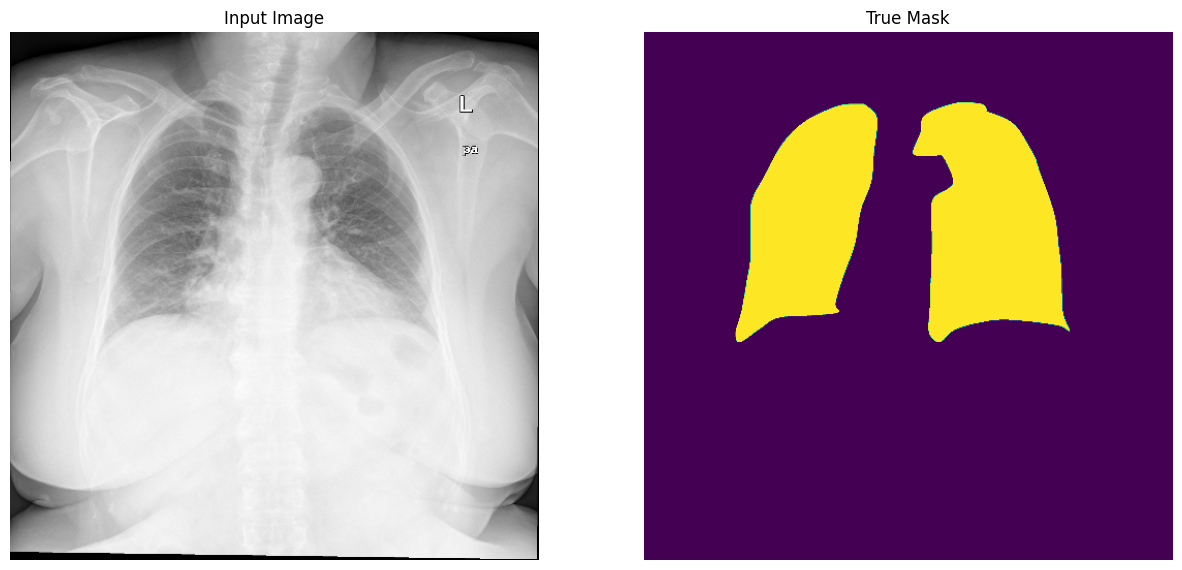

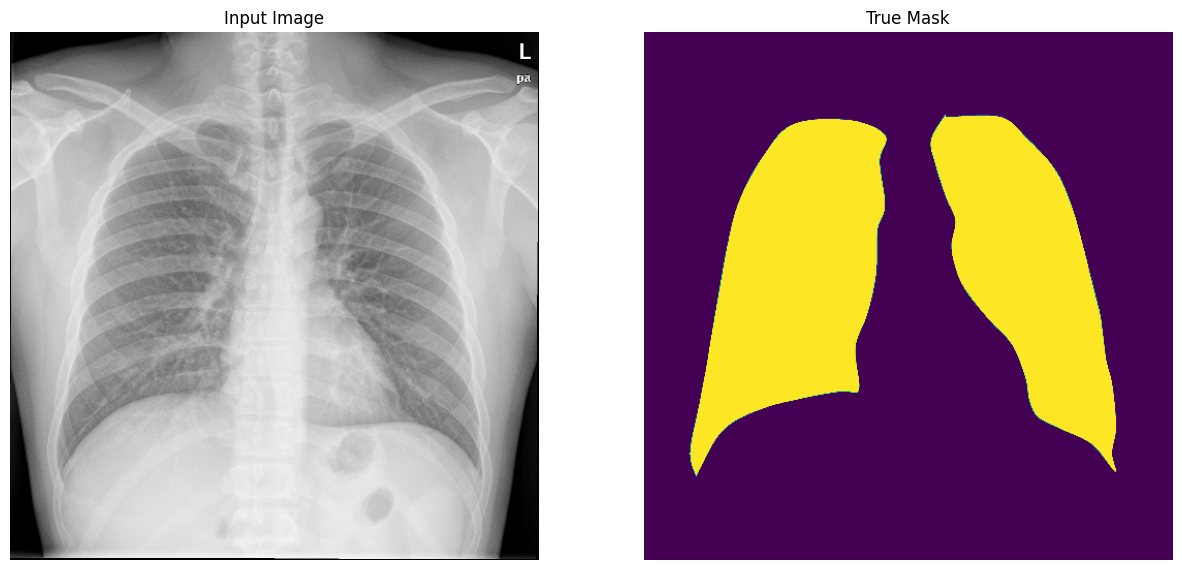

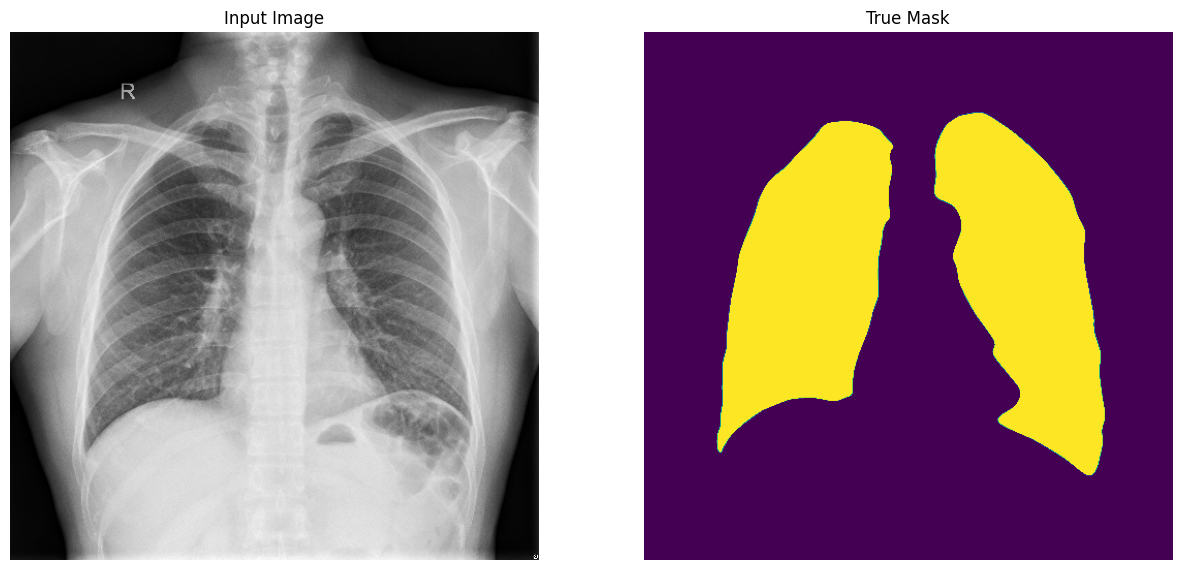

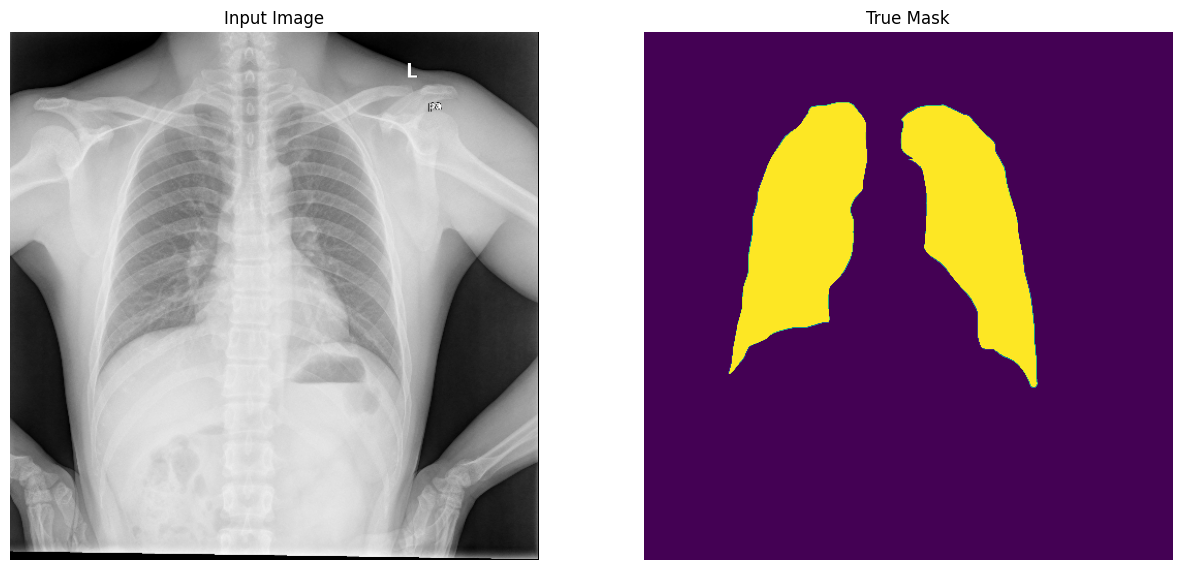

2025-02-06 21:24:07.951709: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in dataset.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

#### Load images
There are 2 types of the image names in the image and masks folders, thus, I get the file names and split them in `set1` and `set2`. Also, to get the labels for the images and masks, the file names are as follows:

example for `set1`: image -> `MCUCXR_0001_0.png`, mask -> `MCUCXR_0001_0.png` where 0 is the label

example for `set2`: image -> `CHNCXR_0001_0.png`, mask -> `CHNCXR_0001_0_mask.png` where 0 is the label

As it is indicated above, when parsing the masks names to get the labels, the masks file name formats are different which should be taken into account.

#### Organize images and masks
The lung images and the corresponding masks have labels where `0` means normal and `1` means abnormal lungs.
The organizer functionality categorizes the images and masks under the corresponding labels.

#### Image preprocessing and loading 

In [6]:
def preprocess_images(image):
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0, 1]
    return image

def preprocess_masks(mask):
    mask = tf.cast(mask, tf.uint8)
    
    # if the pixel values are 100 or more, consider it as white/ lung
    # else, consider it as black/ surroundings 
    mask = tf.where(mask>=100, 1, 0)

    return mask